# Parent-Child Training Experiment
This notebook first trains a cohort of "adult" agents, then freezes their models, adds new "child" agents, and only trains the newcomers while the adults act as fixed mentors. 
All data is stored in a timestamped folder so that analyses can be recreated later.

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import torch
from omegaconf import OmegaConf

from sorrel.action.action_spec import ActionSpec
from sorrel.models.pytorch.iqn import iRainbowModel
from sorrel.examples.leakyemotions.entities import EmptyEntity
from sorrel.examples.leakyemotions.world import LeakyEmotionsWorld
from sorrel.examples.leakyemotions.env import LeakyEmotionsEnv
from sorrel.examples.leakyemotions.agents import LeakyEmotionsAgent
from sorrel.examples.leakyemotions.custom_observation_spec import (
    LeakyEmotionsObservationSpec,
    InteroceptiveObservationSpec,
    OtherOnlyObservationSpec,
    NoEmotionObservationSpec,
)
from sorrel.utils.logging import JupyterLogger
from sorrel.utils.visualization import ImageRenderer

plt.style.use('ggplot')


In [36]:
CONFIG_PATH = Path('sorrel/examples/leakyemotions/configs/default.yaml')

ADULT_EPOCHS = 200
CHILD_EPOCHS = 100
CHILD_COUNT = 3
EVAL_EPOCHS = 75

config = OmegaConf.load(CONFIG_PATH)
config.experiment.epochs = ADULT_EPOCHS
config.experiment.max_turns = 40
config.experiment.record_period = 50
config.experiment.zero_emotion_after_training = False
config.experiment.zero_emotion_eval_epochs = 0
config.model.emotion_condition = 'full'
config.model.agent_vision_radius = 3
config.world.agents = 6
config.world.wolves = 0

world = LeakyEmotionsWorld(config=config, default_entity=EmptyEntity())
experiment = LeakyEmotionsEnv(world, config)
print(f'Environment ready with {len(experiment.agents)} adult agents')


Environment ready with 6 adult agents


In [37]:
RUN_LABEL = 'agents_only_a200_c100_e75_6adult_3child'  # TODO update between runs
RUNS_ROOT = Path('runs_parent_child')
timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
RUN_DIR = RUNS_ROOT / f'{timestamp}_{RUN_LABEL}'
RUN_DIR.mkdir(parents=True, exist_ok=True)


In [38]:
ENTITY_LIST = ['EmptyEntity', 'Bush', 'Wall', 'Grass', 'LeakyEmotionsAgent', 'Wolf']

def build_observation_spec(condition: str, vision_radius: int):
    if condition == 'full':
        spec = LeakyEmotionsObservationSpec(ENTITY_LIST, full_view=False, vision_radius=vision_radius)
    elif condition == 'self':
        spec = InteroceptiveObservationSpec(ENTITY_LIST, full_view=False, vision_radius=vision_radius)
    elif condition == 'other':
        spec = OtherOnlyObservationSpec(ENTITY_LIST, full_view=False, vision_radius=vision_radius)
    else:
        spec = NoEmotionObservationSpec(ENTITY_LIST, full_view=False, vision_radius=vision_radius)
    spec.override_input_size(np.zeros(spec.input_size, dtype=int).reshape(1, -1).shape)
    return spec

def create_untrained_agent(cfg) -> LeakyEmotionsAgent:
    observation_spec = build_observation_spec(cfg.model.emotion_condition, cfg.model.agent_vision_radius)
    action_spec = ActionSpec(['up', 'down', 'left', 'right'])
    model = iRainbowModel(
        input_size=observation_spec.input_size,
        action_space=action_spec.n_actions,
        layer_size=250,
        epsilon=0.05,
        device='cpu',
        seed=torch.random.seed(),
        n_frames=5,
        n_step=3,
        sync_freq=200,
        model_update_freq=4,
        batch_size=64,
        memory_size=1024,
        LR=0.00025,
        TAU=0.001,
        GAMMA=0.99,
        n_quantiles=12,
    )
    return LeakyEmotionsAgent(observation_spec=observation_spec, action_spec=action_spec, model=model)

def freeze_agent_models(agent_list):
    for agent in agent_list:
        model = agent.model
        if hasattr(model, 'eval'):
            model.eval()
        parameters = getattr(model, 'parameters', None)
        if callable(parameters):
            for param in parameters():
                if hasattr(param, 'requires_grad_'):
                    param.requires_grad_(False)

def set_agent_mode(agent_list, train: bool):
    for agent in agent_list:
        model = agent.model
        if hasattr(model, 'train'):
            model.train(mode=train)

def run_evaluation(env: LeakyEmotionsEnv, epochs: int) -> np.ndarray:
    rewards = []
    previous_modes = []
    for agent in env.agents:
        model = agent.model
        previous_modes.append(getattr(model, 'training', False))
        if hasattr(model, 'eval'):
            model.eval()
    for epoch in range(epochs):
        env.reset()
        for agent in env.agents:
            agent.model.start_epoch_action(epoch=epoch)
        bunnies_left = sum(agent.alive for agent in env.bunnies)
        while env.turn < env.config.experiment.max_turns and bunnies_left > 0:
            env.take_turn()
            bunnies_left = sum(agent.alive for agent in env.bunnies)
        env.world.is_done = True
        rewards.append(env.world.total_reward)
    for agent, mode in zip(env.agents, previous_modes):
        if hasattr(agent.model, 'train'):
            agent.model.train(mode=mode)
    return np.array(rewards)

def run_child_training(env: LeakyEmotionsEnv, child_agents: list, epochs: int, logger: JupyterLogger | None,
                       animate: bool = False, output_dir: Path | None = None) -> None:
    """Train only the provided child agents while optionally recording animations."""
    assert child_agents, "child_agents list cannot be empty"
    max_turns = env.config.experiment.max_turns
    record_period = env.config.experiment.record_period
    epsilon_decay = getattr(env.config.model, "epsilon_decay", 0.0)
    renderer = None
    if animate:
        if output_dir is None:
            output_dir = Path('animations')
        output_dir.mkdir(parents=True, exist_ok=True)
        renderer = ImageRenderer(
            experiment_name=env.world.__class__.__name__,
            record_period=record_period,
            num_turns=max_turns,
        )
    for epoch in range(epochs + 1):
        env.reset()
        for agent in env.agents:
            agent.model.start_epoch_action(epoch=epoch)
        animate_this_turn = animate and (epoch % record_period == 0)
        bunnies_left = sum(agent.alive for agent in env.bunnies)
        while env.turn < max_turns and bunnies_left > 0:
            if animate_this_turn and renderer is not None:
                renderer.add_image(env.world)
            env.take_turn()
            bunnies_left = sum(agent.alive for agent in env.bunnies)
        env.world.is_done = True
        if animate_this_turn and renderer is not None:
            renderer.save_gif(epoch, output_dir)
        total_loss = 0.0
        for agent in child_agents:
            loss = agent.model.train_step()
            total_loss += loss
            agent.model.epsilon_decay(epsilon_decay)
        if logger is not None:
            logger.record_turn(epoch, total_loss, env.world.total_reward, child_agents[0].model.epsilon)


In [39]:
adult_logger = JupyterLogger(max_epochs=ADULT_EPOCHS + 1)
adult_anim_dir = RUN_DIR / 'animations/adult_training'
adult_anim_dir.mkdir(parents=True, exist_ok=True)
experiment.run_experiment(animate=True, logger=adult_logger, output_dir=adult_anim_dir)
adult_rewards = np.array(adult_logger.rewards)
print(f'Adult training complete. Final reward: {adult_rewards[-1]:.2f}')
np.save(RUN_DIR / 'adult_training_rewards.npy', adult_rewards)
adult_logger.to_csv(RUN_DIR / 'adult_training_log.csv')
adult_agents = list(experiment.agents)


╔══════════════╦══════════════╦══════════════╗
║ Epoch:   200 ║ Loss:   0.28 ║ Reward:17.81959747628654 ║
╚══════════════╩══════════════╩══════════════╝
Adult training complete. Final reward: 17.82


In [40]:
freeze_agent_models(adult_agents)
set_agent_mode(adult_agents, train=False)
child_agents = [create_untrained_agent(config) for _ in range(CHILD_COUNT)]
for child in child_agents:
    child.model.train()
    experiment.agents.append(child)
    experiment.bunnies.append(child)
config.world.agents = len(experiment.agents)
print(f'Added {len(child_agents)} child agents. Total agents: {len(experiment.agents)}')


Added 3 child agents. Total agents: 9


In [41]:
config.experiment.epochs = CHILD_EPOCHS
child_logger = JupyterLogger(max_epochs=CHILD_EPOCHS + 1)
guided_anim_dir = RUN_DIR / 'animations/guided_child_training'
guided_anim_dir.mkdir(parents=True, exist_ok=True)
run_child_training(
    experiment,
    child_agents,
    CHILD_EPOCHS,
    child_logger,
    animate=True,
    output_dir=guided_anim_dir,
)
guided_child_rewards = np.array(child_logger.rewards)
print(f'Child training complete. Final reward: {guided_child_rewards[-1]:.2f}')
np.save(RUN_DIR / 'guided_child_training_rewards.npy', guided_child_rewards)
child_logger.to_csv(RUN_DIR / 'guided_child_training_log.csv')


╔══════════════╦══════════════╦══════════════╗
║ Epoch:   100 ║ Loss:   0.22 ║ Reward:55.25004096889197 ║
╚══════════════╩══════════════╩══════════════╝
Child training complete. Final reward: 55.25


In [42]:
solo_config = OmegaConf.load(CONFIG_PATH)
solo_config.experiment.epochs = CHILD_EPOCHS
solo_config.experiment.max_turns = config.experiment.max_turns
solo_config.experiment.record_period = config.experiment.record_period
solo_config.experiment.zero_emotion_after_training = False
solo_config.experiment.zero_emotion_eval_epochs = 0
solo_config.model.emotion_condition = config.model.emotion_condition
solo_config.model.agent_vision_radius = config.model.agent_vision_radius
solo_config.world.agents = CHILD_COUNT
solo_config.world.wolves = config.world.wolves
solo_world = LeakyEmotionsWorld(config=solo_config, default_entity=EmptyEntity())
solo_experiment = LeakyEmotionsEnv(solo_world, solo_config)
solo_logger = JupyterLogger(max_epochs=CHILD_EPOCHS + 1)
solo_anim_dir = RUN_DIR / 'animations/unguided_child_training'
solo_anim_dir.mkdir(parents=True, exist_ok=True)
solo_experiment.run_experiment(animate=True, logger=solo_logger, output_dir=solo_anim_dir)
unguided_child_rewards = np.array(solo_logger.rewards)
print(f'Unguided child training complete. Final reward: {unguided_child_rewards[-1]:.2f}')
np.save(RUN_DIR / 'unguided_child_training_rewards.npy', unguided_child_rewards)
solo_logger.to_csv(RUN_DIR / 'unguided_child_training_log.csv')


╔══════════════╦══════════════╦══════════════╗
║ Epoch:   100 ║ Loss:   0.44 ║ Reward:0.16948017308931496 ║
╚══════════════╩══════════════╩══════════════╝
Unguided child training complete. Final reward: 0.17


In [43]:
guided_eval = run_evaluation(experiment, epochs=EVAL_EPOCHS)
np.save(RUN_DIR / 'guided_child_eval.npy', guided_eval)

unguided_eval = run_evaluation(solo_experiment, epochs=EVAL_EPOCHS)
np.save(RUN_DIR / 'unguided_child_eval.npy', unguided_eval)

comparison_df = pd.DataFrame({
    'phase': ['children_with_adult_guidance', 'children_without_guidance'],
    'avg_reward': [np.mean(guided_eval), np.mean(unguided_eval)],
    'std_reward': [np.std(guided_eval), np.std(unguided_eval)],
})
comparison_df.to_csv(RUN_DIR / 'parent_child_summary.csv', index=False)
display(comparison_df)


,phase,avg_reward,std_reward
0,children_with_adult_guidance,19.098841,15.875528
1,children_without_guidance,-0.244385,8.682221


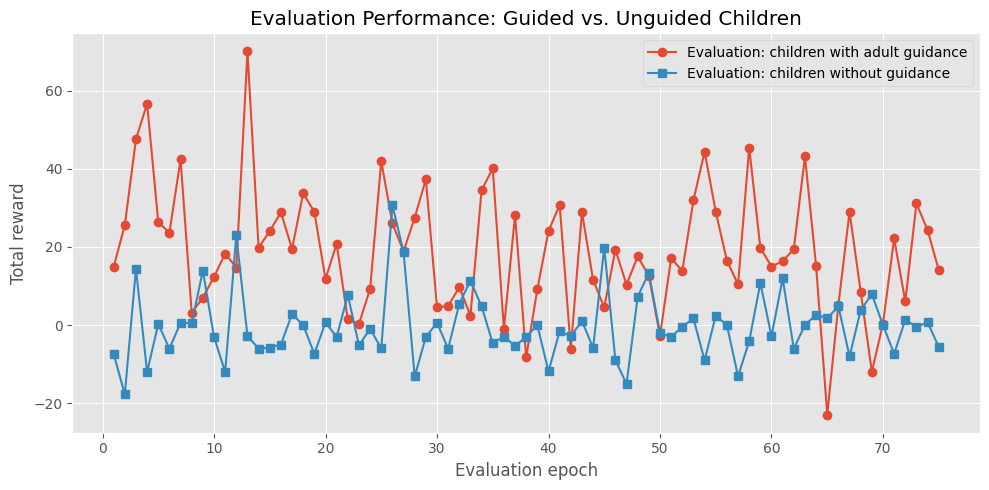

In [44]:
plt.figure(figsize=(10, 5))
epochs = np.arange(1, len(guided_eval) + 1)
plt.plot(epochs, guided_eval, label='Evaluation: children with adult guidance', marker='o')
plt.plot(epochs, unguided_eval, label='Evaluation: children without guidance', marker='s')
plt.xlabel('Evaluation epoch')
plt.ylabel('Total reward')
plt.title('Evaluation Performance: Guided vs. Unguided Children')
plt.legend()
plt.tight_layout()
plt.savefig(RUN_DIR / 'parent_child_evaluation_plot.png', dpi=200)
plt.show()
